<a href="https://colab.research.google.com/github/kramerkraus/2155-CP3-mkraus/blob/main/sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#make it so i can access files in the folder 2155-CP3-mkraus
import sys
sys.path.append('2155-CP3-mkraus/')
from utils import *
from evaluate import *

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Load dataset from CSV files
data_dir = '/content/2155-CP3-mkraus/dataset'
splits = load_dataset_splits(data_dir)

# Get feature names from the CSV file
feature_names = pd.read_csv(os.path.join(data_dir, 'train_original.csv')).columns.tolist()
print(f"\n✓ Features loaded: {len(feature_names)} features")
print(f"Feature names: {feature_names[:5]}...{feature_names[-5:]}")  # Show first and last 5

Loading dataset splits from: /content/2155-CP3-mkraus/dataset

Loading train split...
  ✓ train_original.csv: (2998, 37)
  ✓ train_imputed.csv: (2998, 37)
  ✓ train_missing_mask.csv: (2998, 37)

Loading val split...
  ✓ val_original.csv: (375, 37)
  ✓ val_imputed.csv: (375, 37)
  ✓ val_missing_mask.csv: (375, 37)

Loading test split...
  ✓ test_original.csv: (375, 37)
  ✓ test_imputed.csv: (375, 37)
  ✓ test_missing_mask.csv: (375, 37)

Loading test2 split...
  ✓ test2_imputed.csv: (417, 37)
  ✓ test2_missing_mask.csv: (417, 37)

✓ Features loaded: 37 features
Feature names: ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']...['Feature 33', 'Feature 34', 'Feature 35', 'Feature 36', 'Feature 37']


In [3]:
# Data exploration and analysis
print("\n" + "="*70)
print("DATASET ANALYSIS")
print("="*70)

# Extract data for easier access
X_train = splits['train']['imputed']
mask_train = splits['train']['missing_mask']
X_train_original = splits['train']['original']

X_val = splits['val']['imputed']
mask_val = splits['val']['missing_mask']
X_val_original = splits['val']['original']

X_test = splits['test']['imputed']
mask_test = splits['test']['missing_mask']
X_test_original = splits['test']['original']

# Test2 data (no original available for evaluation)
X_test2 = splits['test2']['imputed']
mask_test2 = splits['test2']['missing_mask']

print(f"\nData shapes:")
print(f"  - Training: {X_train.shape}")
print(f"  - Validation: {X_val.shape}")
print(f"  - Test: {X_test.shape}")
print(f"  - Test2: {X_test2.shape} (evaluation set - no ground truth)")


DATASET ANALYSIS

Data shapes:
  - Training: (2998, 37)
  - Validation: (375, 37)
  - Test: (375, 37)
  - Test2: (417, 37) (evaluation set - no ground truth)


In [4]:
# Data Preprocessing (Handle Missing Values)

print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Handle missing values properly
print("Processing missing values and preparing data...")
print("Mask convention: True=missing, False=observed (in original masks)")

print(f"\n✓ Data preprocessing completed successfully")
print(f"  - Training data range: [{X_train_original[~mask_train].min():.3f}, {X_train_original[~mask_train].max():.3f}]")
print(f"  - Validation data range: [{X_val_original[~mask_val].min():.3f}, {X_val_original[~mask_val].max():.3f}]")
print(f"  - Test data range: [{X_test_original[~mask_test].min():.3f}, {X_test_original[~mask_test].max():.3f}]")

# Create data loaders
batch_size = 64
print(f"\nCreating data loaders with batch size: {batch_size}")

train_dataset = TensorDataset(torch.FloatTensor(X_train_original), torch.FloatTensor((~mask_train).astype(float)))
val_dataset = TensorDataset(torch.FloatTensor(X_val_original), torch.FloatTensor((~mask_val).astype(float)))
test_dataset = TensorDataset(torch.FloatTensor(X_test_original), torch.FloatTensor((~mask_test).astype(float)))
test2_dataset = TensorDataset(torch.FloatTensor(X_test2), torch.FloatTensor((~mask_test2).astype(float)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=False)

# Preview a batch
sample_batch_data, sample_batch_mask = next(iter(train_loader))
print(f"\nSample batch shape: {sample_batch_data.shape}")
print(f"Sample batch mask shape: {sample_batch_mask.shape}")
print(f"Sample batch missing percentage: {(sample_batch_mask == 0).float().mean().item()*100:.1f}%")  # 0 = missing in model tensors



DATA PREPROCESSING
Processing missing values and preparing data...
Mask convention: True=missing, False=observed (in original masks)

✓ Data preprocessing completed successfully
  - Training data range: [0.000, 1.000]
  - Validation data range: [0.000, 1.000]
  - Test data range: [0.000, 1.000]

Creating data loaders with batch size: 64

Sample batch shape: torch.Size([64, 37])
Sample batch mask shape: torch.Size([64, 37])
Sample batch missing percentage: 22.2%


In [5]:
# VAE Model Architecture for Missing Value Imputation
class VAE(nn.Module):
    """
    Variational Autoencoder designed for missing value imputation.

    Key features:
    - Handles arbitrary missing patterns through masking
    - Learns feature dependencies in latent space
    - Generates probabilistic imputations
    - Uses residual connections and dropout for robustness
    """

    def __init__(self, input_dim, latent_dim=64, hidden_dims=[256, 128, 64],
                 use_residual=True, dropout_rate=0.3):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.use_residual = use_residual
        self.hidden_dims = hidden_dims

        # Feature importance network (learns which features are important for each position)
        self.feature_importance = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dims[0] // 2),  # input + mask
            nn.ReLU(),
            nn.Linear(hidden_dims[0] // 2, input_dim),
            nn.Sigmoid()
        )

        # Encoder with residual connections
        self.encoder_layers = nn.ModuleList()
        prev_dim = input_dim * 2  # input + mask

        for i, hidden_dim in enumerate(hidden_dims):
            self.encoder_layers.append(nn.Sequential(
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ))
            prev_dim = hidden_dim

        # Latent space
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # Initialize latent layers with smaller weights for stability
        nn.init.xavier_normal_(self.fc_mu.weight, gain=0.1)
        nn.init.xavier_normal_(self.fc_logvar.weight, gain=0.1)
        nn.init.constant_(self.fc_logvar.bias, -2.0)  # Start with low variance

        # Decoder with skip connections
        self.decoder_layers = nn.ModuleList()
        prev_dim = latent_dim + input_dim + input_dim  # latent + observed + positional encoding

        reversed_dims = list(reversed(hidden_dims))
        for i, hidden_dim in enumerate(reversed_dims):
            self.decoder_layers.append(nn.Sequential(
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ))
            prev_dim = hidden_dim

        # Final output layer
        self.output_layer = nn.Linear(hidden_dims[0], input_dim)
        nn.init.xavier_normal_(self.output_layer.weight, gain=0.1)

    def encode(self, x, mask):
        """Encode input with missing value masking."""
        # Calculate feature importance weights
        mask_float = mask.float()
        encoder_input = torch.cat([x * mask_float, mask_float], dim=1)
        importance_weights = self.feature_importance(encoder_input)

        # Apply importance weighting to the input
        weighted_input = x * mask_float * importance_weights
        encoder_input = torch.cat([weighted_input, mask_float], dim=1)

        # Pass through encoder layers with residual connections
        h = encoder_input
        skip_connections = []

        for i, layer in enumerate(self.encoder_layers):
            prev_h = h
            h = layer(h)

            # Add residual connection for deeper layers
            if self.use_residual and i > 0 and h.shape == prev_h.shape:
                h = h + prev_h

            skip_connections.append(h)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # Clamp logvar to prevent numerical instability
        logvar = torch.clamp(logvar, min=-10, max=10)

        return mu, logvar, skip_connections

    def reparameterize(self, mu, logvar):
        """Reparameterization trick for VAE."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, x_observed, mask):
        """Decode latent representation conditioned on observed values."""
        # Enhanced conditioning on observed values
        mask_float = mask.float()
        x_masked = x_observed * mask_float

        # Add positional encoding for better feature understanding
        pos_encoding = torch.arange(self.input_dim, dtype=torch.float32, device=z.device)
        pos_encoding = pos_encoding.unsqueeze(0).expand(z.size(0), -1) / self.input_dim

        # Concatenate latent code with observed values and positional encoding
        decoder_input = torch.cat([z, x_masked, pos_encoding], dim=1)

        # Pass through decoder layers
        h = decoder_input
        for layer in self.decoder_layers:
            h = layer(h)

        # Get reconstruction
        reconstruction = self.output_layer(h)

        return reconstruction

    def forward(self, x, mask):
        """Forward pass through VAE."""
        mu, logvar, _ = self.encode(x, mask)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z, x, mask)

        return reconstruction, mu, logvar

    def impute(self, x_incomplete, mask, n_samples=10):
        """Generate multiple imputation samples for missing values."""
        self.eval()

        with torch.no_grad():
            # Get multiple samples from the posterior
            mu, logvar, _ = self.encode(x_incomplete, mask)

            samples = []
            for _ in range(n_samples):
                z = self.reparameterize(mu, logvar)
                reconstruction = self.decode(z, x_incomplete, mask)

                # Combine observed values with imputed values
                mask_float = mask.float()
                imputed = x_incomplete * mask_float + reconstruction * (1 - mask_float)
                samples.append(imputed.cpu().numpy())

            samples = np.stack(samples, axis=1)  # Shape: (batch_size, n_samples, n_features)

        return samples

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder for missing value imputation.
    Handles arbitrary missing masks and generates diverse samples conditioned on observed features.
    """

    def __init__(self, input_dim, latent_dim=64, hidden_dims=[256, 128, 64], dropout_rate=0.3):
        super(CVAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims

        # Encoder network
        self.encoder_layers = nn.ModuleList()
        prev_dim = input_dim * 2  # x + mask

        for h_dim in hidden_dims:
            self.encoder_layers.append(nn.Sequential(
                nn.Linear(prev_dim, h_dim),
                nn.BatchNorm1d(h_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ))
            prev_dim = h_dim

        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder network
        self.decoder_layers = nn.ModuleList()
        prev_dim = latent_dim + input_dim  # z + observed features

        for h_dim in reversed(hidden_dims):
            self.decoder_layers.append(nn.Sequential(
                nn.Linear(prev_dim, h_dim),
                nn.BatchNorm1d(h_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ))
            prev_dim = h_dim

        self.output_layer = nn.Linear(hidden_dims[0], input_dim)

        # Initialization
        nn.init.xavier_normal_(self.fc_mu.weight, gain=0.1)
        nn.init.xavier_normal_(self.fc_logvar.weight, gain=0.1)
        nn.init.constant_(self.fc_logvar.bias, -2.0)
        nn.init.xavier_normal_(self.output_layer.weight, gain=0.1)

    def encode(self, x, mask):
        mask_float = mask.float()
        encoder_input = torch.cat([x * mask_float, mask_float], dim=1)

        h = encoder_input
        for layer in self.encoder_layers:
            h = layer(h)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        logvar = torch.clamp(logvar, min=-10, max=10)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, x_observed, mask):
        mask_float = mask.float()
        x_masked = x_observed * mask_float
        decoder_input = torch.cat([z, x_masked], dim=1)

        h = decoder_input
        for layer in self.decoder_layers:
            h = layer(h)

        reconstruction = self.output_layer(h)
        return reconstruction

    def forward(self, x, mask):
        mu, logvar = self.encode(x, mask)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z, x, mask)
        return reconstruction, mu, logvar

    def impute(self, x_incomplete, mask, n_samples=10):
        self.eval()
        with torch.no_grad():
            mu, logvar = self.encode(x_incomplete, mask)
            samples = []
            for _ in range(n_samples):
                z = self.reparameterize(mu, logvar)
                reconstruction = self.decode(z, x_incomplete, mask)
                mask_float = mask.float()
                imputed = x_incomplete * mask_float + reconstruction * (1 - mask_float)
                samples.append(imputed.cpu().numpy())
            return np.stack(samples, axis=1)


In [76]:
# Loss Functions and Training Utilities

def vae_loss_function(recon_x, x, mu, logvar, mask, beta=1.0):
    """
    Enhanced VAE loss function with missing value handling.

    Args:
        recon_x: Reconstructed data
        x: Original data
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        mask: Binary mask (1 for observed, 0 for missing)
        beta: Weight for KL divergence term
    """
    # Reconstruction loss only on observed values
    #reconstruction_diff = (recon_x - x) ** 2
    reconstruction_diff = torch.abs(recon_x - x)

    # Only consider observed values and normalize properly
    masked_loss = reconstruction_diff * mask
    recon_loss = masked_loss.sum() / (mask.sum() + 1e-8)


    ####################################################
    #add a reconstruction loss for featrue 26 since we know it should be binned
    #this should be done ALL the time
    ####################################################
    #ipdb.set_trace()
    reconf26 = recon_x[:,25]
    f26loss_components = torch.stack([(reconf26-1)**2, (reconf26-0.5)**2,(reconf26)**2], dim=0)
    f26loss = torch.min(f26loss_components, dim=0).values
    #ipdb.set_trace()
    f26loss = f26loss**0.5
    f26loss = f26loss.mean()
    recon_loss = recon_loss + f26loss
    ####################################################

    # Add standard MSE loss for stability
    standard_recon_loss = F.mse_loss(recon_x * mask, x * mask, reduction='mean')
    recon_loss = 0.7 * recon_loss + 0.3 * standard_recon_loss

    # KL divergence with free bits to prevent posterior collapse
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss = kl_loss / x.size(0)  # Normalize by batch size

    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss


def get_beta_schedule(epoch, total_epochs, schedule_type='cosine'):
    """Get beta value for KL annealing schedule."""
    if schedule_type == 'linear':
        return min(1.0, epoch / (total_epochs * 0.5))
    elif schedule_type == 'sigmoid':
        return 1.0 / (1.0 + np.exp(-(epoch - total_epochs * 0.5) / (total_epochs * 0.1)))
    elif schedule_type == 'cosine':
        return 0.5 * (1 + np.cos(np.pi * (1 - epoch / total_epochs)))
    elif schedule_type == 'constant':
        return 1.0
    elif schedule_type == 'none':
        return 0.0
    else:
        return 1.0


def evaluate_imputation(model, data_loader, device):
    """Evaluate imputation performance."""
    model.eval()

    all_imputations = []
    all_originals = []
    all_masks = []

    with torch.no_grad():
        for batch_data, batch_mask in data_loader:
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            # Get model predictions
            reconstruction, mu, logvar = model(batch_data, batch_mask)

            # Combine observed values with imputed values
            mask_float = batch_mask.float()
            imputed = batch_data * mask_float + reconstruction * (1 - mask_float)

            all_imputations.append(imputed.cpu().numpy())
            all_originals.append(batch_data.cpu().numpy())
            all_masks.append(batch_mask.cpu().numpy())

    # Concatenate all results
    imputations = np.vstack(all_imputations)
    originals = np.vstack(all_originals)
    masks = np.vstack(all_masks)

    return imputations, originals, masks

When you run the cell above, execution will pause at `ipdb.set_trace()`. You will see an `ipdb>` prompt. You can then inspect variables, step through the code, or continue execution.

To exit the debugger and continue code execution, type `c` and press Enter. To quit the debugger entirely (and stop the cell's execution), type `q` and press Enter.

In [77]:
print("\n" + "="*70)
print("MODEL TRAINING")
print("="*70)

# Model configuration
config = {
    'input_dim': len(feature_names),
    'latent_dim': 256,
    'hidden_dims': [512, 256, 256],
    'use_residual': True,
    'dropout_rate': 0.3,
    'learning_rate': 1e-3,
    'num_epochs': 500,
    'beta_initial': 1.0,
    'beta_schedule': 'none',
    'patience': 15
}

print(f"Model Configuration:")
for key, value in config.items():
    print(f"  - {key}: {value}")

# # Initialize the model
# print(f"\nInitializing VAE model...")
# model = VAE(
#     input_dim=config['input_dim'],
#     latent_dim=config['latent_dim'],
#     hidden_dims=config['hidden_dims'],
#     use_residual=config['use_residual'],
#     dropout_rate=config['dropout_rate']
# ).to(device)

# Initialize the model
print(f"\nInitializing CVAE model...")
model = CVAE(
    input_dim=config['input_dim'],
    latent_dim=config['latent_dim'],
    hidden_dims=config['hidden_dims'],
    dropout_rate=config['dropout_rate']
).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Model initialized with {total_params:,} parameters")

# Initialize optimizer with improved settings
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=1e-5,
    betas=(0.9, 0.999),
    eps=1e-8
)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=20, T_mult=2, eta_min=1e-6
)

print(f"✓ Optimizer and scheduler initialized")

# Training setup
train_losses = []
val_losses = []
train_recon_losses = []
train_kl_losses = []
best_val_loss = float('inf')
patience_counter = 0
max_grad_norm = 1.0

print(f"\nStarting training for {config['num_epochs']} epochs...")
print("="*70)

# Training loop
for epoch in range(config['num_epochs']):
    # Training phase
    model.train()
    epoch_train_loss = 0
    epoch_recon_loss = 0
    epoch_kl_loss = 0

    # Get beta for this epoch
    beta = get_beta_schedule(epoch, config['num_epochs'], config['beta_schedule'])

    train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["num_epochs"]}', leave=False)

    for batch_data, batch_mask in train_progress:
        batch_data = batch_data.to(device)
        batch_mask = batch_mask.to(device)

        optimizer.zero_grad()

        # Forward pass
        reconstruction, mu, logvar = model(batch_data, batch_mask)

        # Calculate loss
        total_loss, recon_loss, kl_loss = vae_loss_function(
            reconstruction, batch_data, mu, logvar, batch_mask,
            beta=beta
        )

        # Backward pass
        total_loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        # Accumulate losses
        epoch_train_loss += total_loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()

        # Update progress bar
        train_progress.set_postfix({
            'Loss': f'{total_loss.item():.4f}',
            'Recon': f'{recon_loss.item():.4f}',
            'KL': f'{kl_loss.item():.4f}',
            'Beta': f'{beta:.3f}'
        })

    # Calculate average training losses
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_recon_loss = epoch_recon_loss / len(train_loader)
    avg_kl_loss = epoch_kl_loss / len(train_loader)

    # Validation phase
    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for batch_data, batch_mask in val_loader:
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            reconstruction, mu, logvar = model(batch_data, batch_mask)

            total_loss, _, _ = vae_loss_function(
                reconstruction, batch_data, mu, logvar, batch_mask,
                beta=beta
            )

            epoch_val_loss += total_loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)

    # Store losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_recon_losses.append(avg_recon_loss)
    train_kl_losses.append(avg_kl_loss)

    # Learning rate scheduling
    scheduler.step()

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_vae_model.pth')
    else:
        patience_counter += 1

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{config["num_epochs"]}:')
        print(f'  Train Loss: {avg_train_loss:.4f} (Recon: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f})')
        print(f'  Val Loss: {avg_val_loss:.4f}, Best: {best_val_loss:.4f}')
        print(f'  Beta: {beta:.3f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')
        print(f'  Patience: {patience_counter}/{config["patience"]}')

    # Early stopping
    if patience_counter >= config['patience']:
        print(f'\nEarly stopping at epoch {epoch+1}')
        break

print(f'\n✓ Training completed!')
print(f'  - Total epochs: {len(train_losses)}')
print(f'  - Best validation loss: {best_val_loss:.4f}')
print(f'  - Final training loss: {train_losses[-1]:.4f}')

# Load best model
model.load_state_dict(torch.load('best_vae_model.pth'))
print(f'✓ Best model loaded')


MODEL TRAINING
Model Configuration:
  - input_dim: 37
  - latent_dim: 256
  - hidden_dims: [512, 256, 256]
  - use_residual: True
  - dropout_rate: 0.3
  - learning_rate: 0.001
  - num_epochs: 500
  - beta_initial: 1.0
  - beta_schedule: none
  - patience: 15

Initializing CVAE model...
✓ Model initialized with 662,821 parameters
✓ Optimizer and scheduler initialized

Starting training for 500 epochs...


Epoch 10/500:
  Train Loss: 0.1327 (Recon: 0.1327, KL: 372.0721)
  Val Loss: 0.1116, Best: 0.1116
  Beta: 0.000, LR: 5.01e-04
  Patience: 0/15


Epoch 20/500:
  Train Loss: 0.1104 (Recon: 0.1104, KL: 435.4388)
  Val Loss: 0.0912, Best: 0.0912
  Beta: 0.000, LR: 1.00e-03
  Patience: 0/15


Epoch 30/500:
  Train Loss: 0.1125 (Recon: 0.1125, KL: 553.8695)
  Val Loss: 0.0885, Best: 0.0852
  Beta: 0.000, LR: 8.54e-04
  Patience: 2/15


Epoch 40/500:
  Train Loss: 0.1017 (Recon: 0.1017, KL: 594.1705)
  Val Loss: 0.0770, Best: 0.0770
  Beta: 0.000, LR: 5.01e-04
  Patience: 0/15


Epoch 50/500:
  Train Loss: 0.0915 (Recon: 0.0915, KL: 619.9892)
  Val Loss: 0.0694, Best: 0.0694
  Beta: 0.000, LR: 1.47e-04
  Patience: 0/15


Epoch 60/500:
  Train Loss: 0.0884 (Recon: 0.0884, KL: 628.2212)
  Val Loss: 0.0670, Best: 0.0667
  Beta: 0.000, LR: 1.00e-03
  Patience: 3/15


Epoch 70/500:
  Train Loss: 0.0988 (Recon: 0.0988, KL: 622.6224)
  Val Loss: 0.0801, Best: 0.0667
  Beta: 0.000, LR: 9.62e-04
  Patience: 13/15



Early stopping at epoch 72

✓ Training completed!
  - Total epochs: 72
  - Best validation loss: 0.0667
  - Final training loss: 0.0973
✓ Best model loaded


In [78]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Evaluate on test set
print("Evaluating model on test set...")
test_imputations, test_originals, test_masks = evaluate_imputation(
    model, test_loader, device
)

print(f"✓ Test set evaluation completed")
print(f"  - Test samples: {test_imputations.shape[0]}")
print(f"  - Features: {test_imputations.shape[1]}")

test_imputations_denorm = test_imputations  # Already in original scale
test_original_denorm = X_test_original  # Already in original scale

# Calculate comprehensive metrics
print("\nCalculating comprehensive metrics...")
feature_metrics = {}

# Create masks for missing values (where we need to evaluate imputation)
missing_mask = (test_masks == 0)  # True where values were missing (0 in model tensors = missing)

for i, feature_name in enumerate(feature_names):
    if missing_mask[:, i].sum() > 0:  # Only evaluate features with missing values
        # Get imputed and ground truth values for missing positions only
        imputed_missing = test_imputations_denorm[missing_mask[:, i], i]
        ground_truth_missing = test_original_denorm[missing_mask[:, i], i]

        # Calculate metrics
        mse = mean_squared_error(ground_truth_missing, imputed_missing)
        mae = mean_absolute_error(ground_truth_missing, imputed_missing)

        # Correlation
        try:
            correlation = np.corrcoef(ground_truth_missing, imputed_missing)[0, 1]
        except:
            correlation = np.nan

        # Mean difference and Jensen-Shannon divergence
        mean_diff, js_div = calculate_jsd_and_mean_diff(
            imputed_missing, ground_truth_missing, feature_name
        )

        feature_metrics[feature_name] = {
            'n_missing': missing_mask[:, i].sum(),
            'mse': mse,
            'mae': mae,
            'correlation': correlation,
            'mean_difference': mean_diff,
            'js_divergence': js_div,
        }

print(f"✓ Metrics calculated for {len(feature_metrics)} features with missing values")

# Display metrics for last 4 features (as requested)
print(f"\n" + "="*100)
print("METRICS FOR LAST 4 FEATURES")
print("="*100)
print(f"{'Feature':<15} {'N_Miss':<8} {'MSE':<10} {'MAE':<10} {'Corr':<8} {'Mean_Diff':<10} {'JS_Div':<8}")
print("-" * 100)

last_4_features = list(feature_metrics.keys())[-4:] if len(feature_metrics) >= 4 else list(feature_metrics.keys())

for feature in last_4_features:
    metrics = feature_metrics[feature]
    print(f"{feature:<15} {metrics['n_missing']:<8} {metrics['mse']:<10.4f} {metrics['mae']:<10.4f} "
          f"{metrics['correlation']:<8.3f} {metrics['mean_difference']:<10.4f} {metrics['js_divergence']:<8.4f} ")

# Summary statistics
all_mse = [m['mse'] for m in feature_metrics.values() if not np.isnan(m['mse'])]
all_mae = [m['mae'] for m in feature_metrics.values() if not np.isnan(m['mae'])]
all_corr = [m['correlation'] for m in feature_metrics.values() if not np.isnan(m['correlation'])]
all_mean_diff = [m['mean_difference'] for m in feature_metrics.values() if not np.isnan(m['mean_difference'])]
all_js_div = [m['js_divergence'] for m in feature_metrics.values() if not np.isnan(m['js_divergence'])]

print(f"\nSummary Statistics Across All Features:")
print(f"  - Average MSE: {np.mean(all_mse):.4f} ± {np.std(all_mse):.4f}")
print(f"  - Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")
print(f"  - Average Correlation: {np.mean(all_corr):.3f} ± {np.std(all_corr):.3f}")
print(f"  - Average Mean Difference: {np.mean(all_mean_diff):.4f} ± {np.std(all_mean_diff):.4f}")
print(f"  - Average JS Divergence: {np.mean(all_js_div):.4f} ± {np.std(all_js_div):.4f}")


MODEL EVALUATION
Evaluating model on test set...
✓ Test set evaluation completed
  - Test samples: 375
  - Features: 37

Calculating comprehensive metrics...
✓ Metrics calculated for 37 features with missing values

METRICS FOR LAST 4 FEATURES
Feature         N_Miss   MSE        MAE        Corr     Mean_Diff  JS_Div  
----------------------------------------------------------------------------------------------------
Feature 34      75       0.0083     0.0746     0.597    0.0244     0.4796   
Feature 35      75       0.0567     0.2028     0.433    0.1655     0.6091   
Feature 36      75       0.0152     0.1070     0.894    0.0751     0.5335   
Feature 37      75       0.0309     0.1365     0.831    0.0558     0.5092   

Summary Statistics Across All Features:
  - Average MSE: 0.1268 ± 0.0896
  - Average MAE: 0.2658 ± 0.1177
  - Average Correlation: 0.324 ± 0.296
  - Average Mean Difference: 0.2218 ± 0.1254
  - Average JS Divergence: 0.6011 ± 0.1020


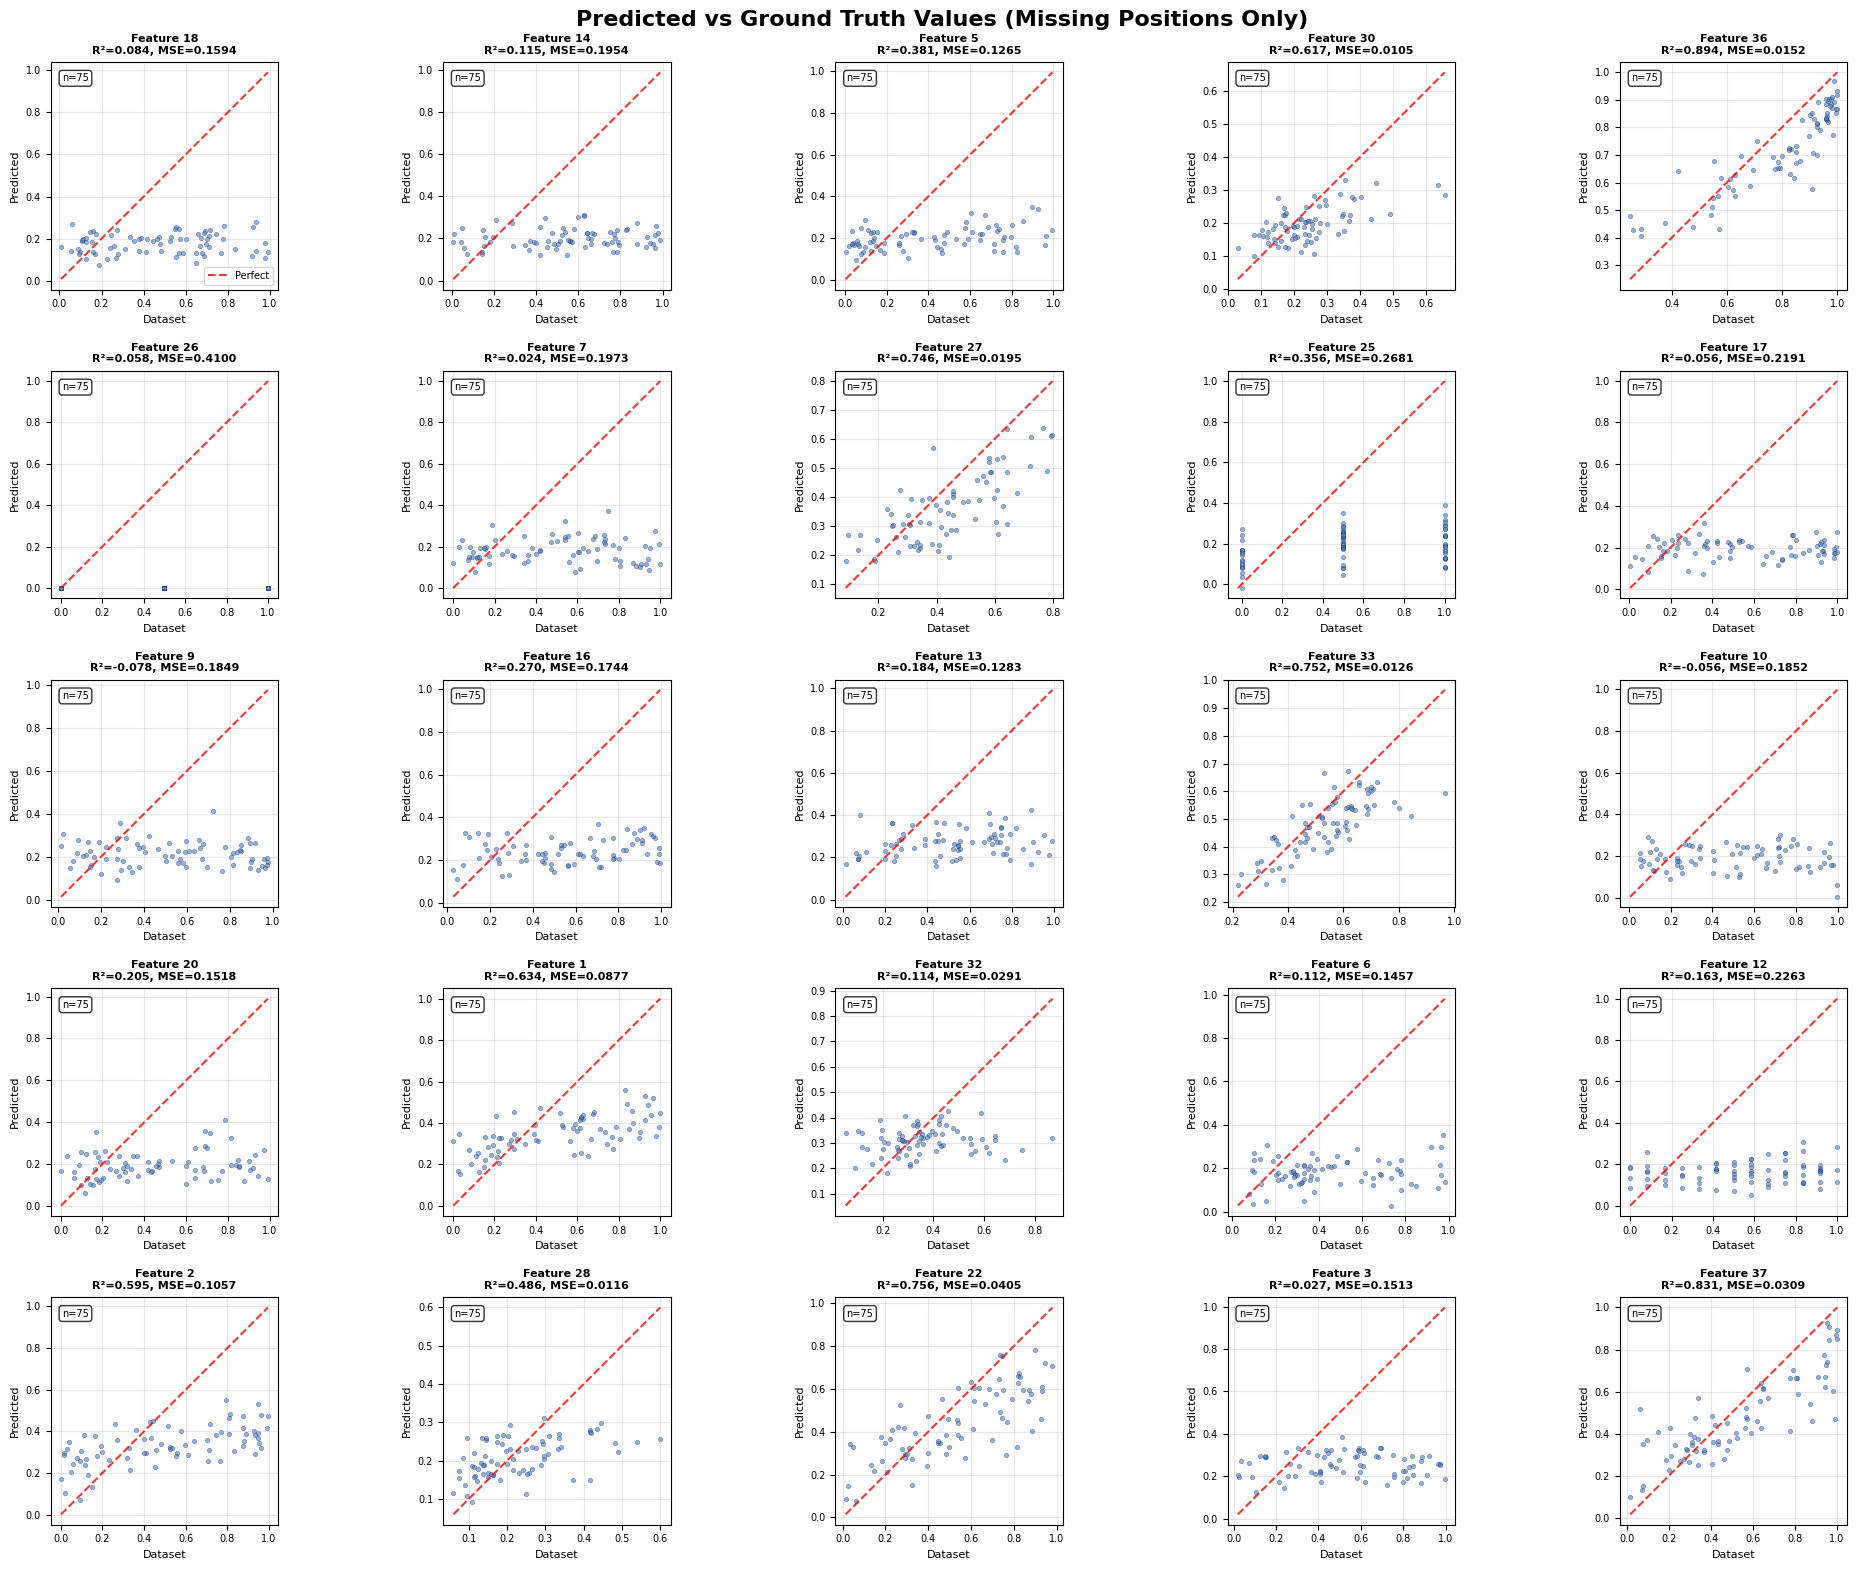

In [79]:
# Create the visualization
plot_prediction_scatter(test_imputations_denorm, test_original_denorm, test_masks, feature_names, n_features=37)



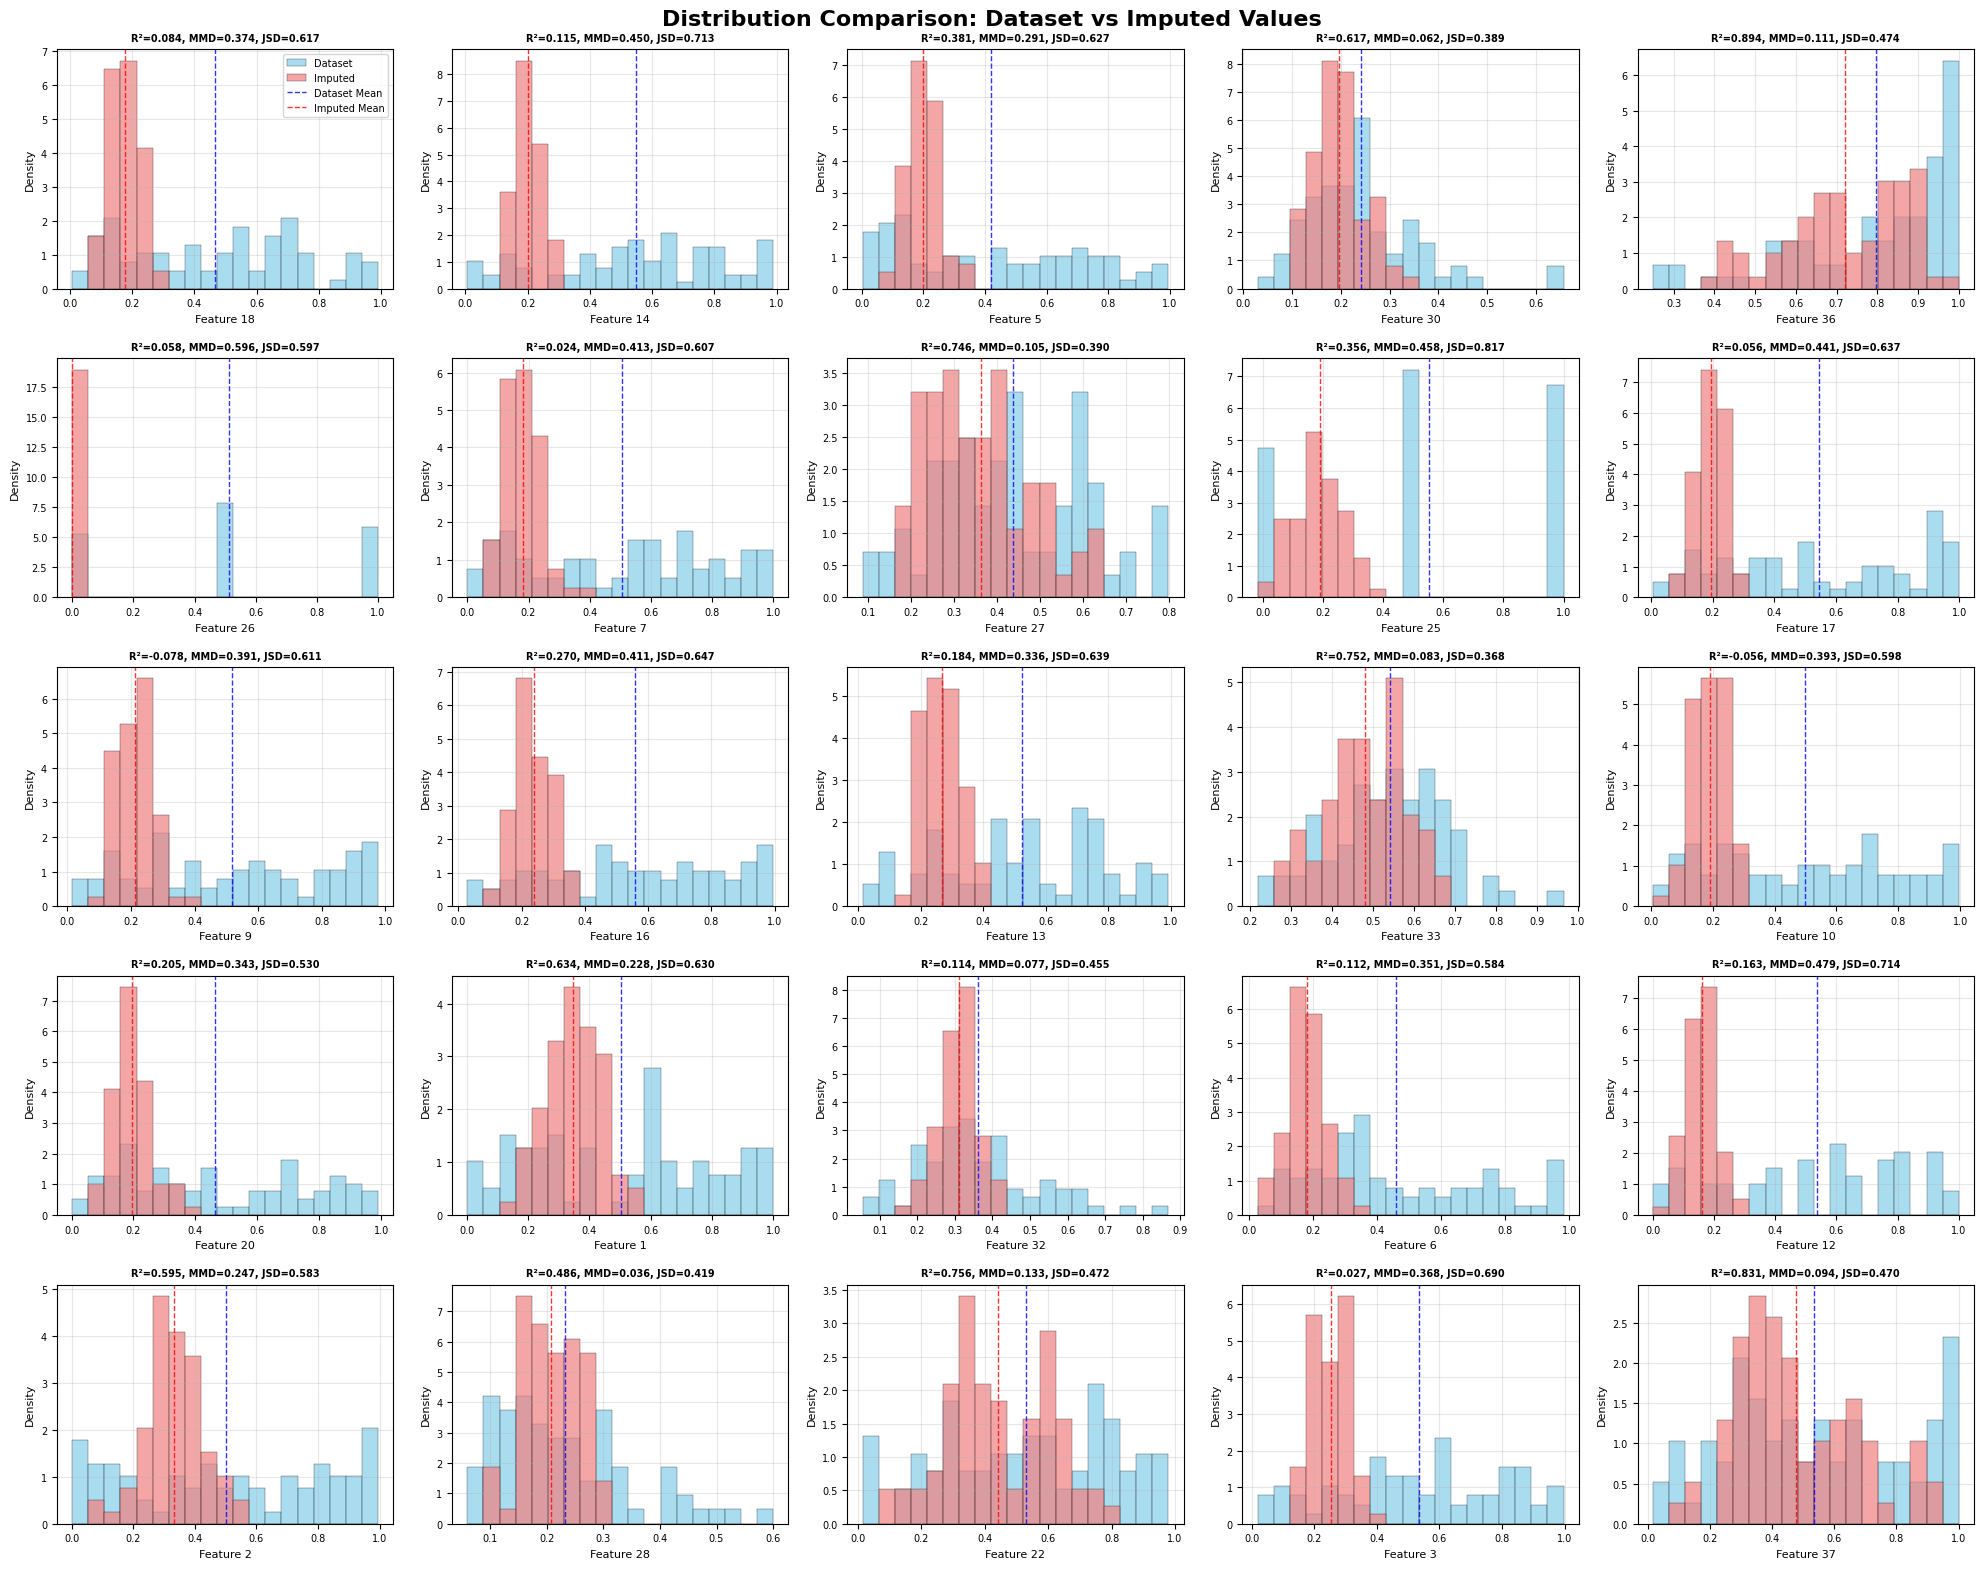

In [80]:
# Distribution comparison plots
plot_distribution_comparison(test_imputations_denorm, test_original_denorm,
                             test_masks, feature_names, n_features=37)


In [81]:
def generate_samples(model, X_test, test_loader, device, n_samples_per_test=100):
    """Generate multiple samples for a dataset using the trained model.
    """
    # We'll generate multiple samples
    test_samples = np.zeros((X_test.shape[0], n_samples_per_test, X_test.shape[1]))

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Create a progress bar for all samples
        from tqdm import tqdm

        for batch_idx, (batch_data, batch_mask) in enumerate(tqdm(test_loader, desc="Generating Samples")):
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            # Calculate the indices for this batch
            start_idx = batch_idx * test_loader.batch_size
            end_idx = min(start_idx + test_loader.batch_size, X_test.shape[0])
            actual_batch_size = end_idx - start_idx

            # Generate multiple samples for each item in the batch
            for j in range(n_samples_per_test):
                # Get reconstruction
                reconstruction, mu, logvar = model(batch_data, batch_mask) # TODO: Change this line based on the model you use

                # Apply mask: keep original values where available, use reconstructed values where missing
                mask_float = batch_mask.float()
                imputed = batch_data * mask_float + reconstruction * (1 - mask_float)

                # Store the samples (already in original scale since we didn't normalize)
                test_samples[start_idx:end_idx, j, :] = imputed.cpu().numpy()
    print(f"✓ Generated samples shape: {test_samples.shape}")
    print(f"  - {test_samples.shape[0]} samples")
    print(f"  - {test_samples.shape[1]} generated variations per sample")
    print(f"  - {test_samples.shape[2]} features per sample")

    # Data is already in original scale (no denormalization needed)
    test_samples_final = test_samples.copy()

    # Calculate summary statistics
    mean_across_samples = test_samples_final.mean(axis=1)  # Mean across the 100 samples

    print(f"  - Range of means: [{mean_across_samples.min():.4f}, {mean_across_samples.max():.4f}]")

    return test_samples

In [82]:
# Test Evaluation

print("="*70)
print("TEST EVALUATION")
print("="*70)

# Generate multiple samples for test using the trained model
print(f"Generating 100 samples for each of {X_test.shape[0]} test samples...")

test_samples = generate_samples(
    model, X_test, test_loader, device, n_samples_per_test=100
)

TEST EVALUATION
Generating 100 samples for each of 375 test samples...


Generating Samples: 100%|██████████| 6/6 [00:01<00:00,  5.08it/s]

✓ Generated samples shape: (375, 100, 37)
  - 375 samples
  - 100 generated variations per sample
  - 37 features per sample
  - Range of means: [-0.0260, 1.0000]


In [83]:
import importlib
import evaluate

# Reload the evaluate module to reflect any changes
importlib.reload(evaluate)

print("✅ evaluate.py module reloaded. Changes should now be reflected.")

✅ evaluate.py module reloaded. Changes should now be reflected.


In [84]:
from evaluate import *
test_score = compute_score(generated_samples=test_samples, set_name='test')
print("Test score:", test_score)

Loading data...
✓ Found data in current directory
✓ Test data shape: (375, 37)
✓ Missing ratio: 20.0%
✓ Generated samples shape: (375, 100, 37)

📊 EVALUATION RESULTS
Missing values evaluated: 2,775
MSE          : 0.1266
MAE          : 0.2654
Correlation  : 0.308
JS Divergence: 0.1668

📈 FEATURE-WISE RESULTS
Feature  MSE        MAE        Corr     JSDiv    Count   
0        0.0862     0.2375     0.651    0.4151   75      
1        0.1056     0.2699     0.595    0.3810   75      
2        0.1501     0.3216     0.033    0.4938   75      
3        0.2068     0.3748     -0.183   0.4593   75      
4        0.1271     0.2833     0.393    0.4241   75      
5        0.1455     0.2998     0.118    0.3870   75      
6        0.1961     0.3562     0.044    0.3887   75      
7        0.1314     0.2895     -0.018   0.4111   75      
8        0.1853     0.3486     -0.092   0.4281   75      
9        0.1813     0.3398     -0.007   0.3970   75      
10       0.1430     0.2979     0.116    0.3874   75  

In [86]:
# Test2 Evaluation

print("="*70)
print("TEST2 EVALUATION")
print("="*70)

# Generate multiple samples for test2 using the trained model
print(f"Generating 100 samples for each of {X_test2.shape[0]} test2 samples...")

test2_samples = generate_samples(
    model, X_test2, test2_loader, device, n_samples_per_test=100
)

TEST2 EVALUATION
Generating 100 samples for each of 417 test2 samples...


Generating Samples: 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]

✓ Generated samples shape: (417, 100, 37)
  - 417 samples
  - 100 generated variations per sample
  - 37 features per sample
  - Range of means: [-0.0004, 1.0000]


In [90]:
id = np.random.randint(1e8, 1e9-1)
np.save(f"{id}.npy", test2_samples)